In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from glob import glob
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from matplotlib.colors import BoundaryNorm, TwoSlopeNorm
from S2S.data_handler import BarentsWatch
import os
from S2S.graphics import latex
from scripts.Henrik.process_data import interpolate_norkyst_to_barentswatch,fit_models
from S2S.process import Hindcast, Observations
import S2S.scoring as sc

from S2S.xarray_helpers import o_climatology
from scripts.Henrik.distance_from_coast import get_shore
import cmocean
import properscoring as ps

from scipy.stats import pearsonr

Compute CRPS, MAE and ACC for all prediction approaches w.r.t Norkyst800 (nearest grid point to BW stations)

In [2]:
dpath = '/projects/NS9853K/DATA/tmp/'
FPATH = '/projects/NS9001K/owul/figures/S2S_fishfarm/final/'

In [3]:
# nk_path = dpath + "norkyst_at_locations_hardanger_stationary_kindex.nc"

# with xr.open_dataarray(nk_path) as norkyst:
#     norkyst = norkyst.sortby("time")

# print('Norkyst: roll')
# norkyst = norkyst.rolling(time=7,center=True).mean()

# hindcast = fit_models.HC()
# observations = Observations(
#         name='norkyst_at_locations_hardanger_stacked_and_processed',
#         observations=norkyst,
#         forecast=hindcast,
#         process=True   
#     )
# observations.data_a.to_netcdf(dpath+'norkyst_at_locations_hardanger_anomalies.nc')

In [4]:
obs_anom = xr.open_dataarray(dpath+'norkyst_at_locations_hardanger_anomalies.nc')

In [5]:
CMB_adj = xr.open_dataarray(dpath+'combo_at_locations_hardanger_adjusted.nc')
CMB = xr.open_dataarray(dpath+'combo_at_locations_hardanger.nc')
PRS_adj = xr.open_dataarray(dpath+'pers_at_locations_hardanger_adjusted.nc')
PRS = xr.open_dataarray(dpath+'pers_at_locations_hardanger.nc')
EC_bc = xr.open_dataarray(dpath+'hindcast_at_locations_hardanger.nc')

In [6]:
CMB_adj,CMB,PRS_adj,PRS,EC_bc,obs_anom = xr.align(CMB_adj,CMB,PRS_adj,PRS,EC_bc,obs_anom)
obs_anom = obs_anom.transpose('step','location','time')
EC_bc = EC_bc.transpose('step','location','time','member')

In [7]:
obs_anom.shape,CMB_adj.shape

((5, 214, 680), (5, 214, 680))

In [8]:
corr_ex_CMB     = xr.corr(CMB,obs_anom,dim='time')
corr_ex_CMB_adj = xr.corr(CMB_adj,obs_anom,dim='time')
corr_ex_PRS     = xr.corr(PRS,obs_anom,dim='time')
corr_ex_PRS_adj = xr.corr(PRS_adj,obs_anom,dim='time')
corr_ex_EC      = xr.corr(EC_bc.mean('member'),obs_anom,dim='time')
corr_ex_CLM     = xr.DataArray(np.zeros_like(corr_ex_EC.values),dims=corr_ex_PRS_adj.dims,coords=corr_ex_PRS_adj.coords)

In [9]:
mae_ex_CLM      = abs(obs_anom).mean('time')
mae_ex_CMB      = abs(obs_anom - CMB).mean('time')
mae_ex_CMB_adj  = abs(obs_anom - CMB_adj).mean('time')
mae_ex_PRS      = abs(obs_anom - PRS).mean('time')
mae_ex_PRS_adj  = abs(obs_anom - PRS_adj).mean('time')
mae_ex_EC       = abs(obs_anom - EC_bc.mean('member')).mean('time')

In [10]:
CMB_wspread = (EC_bc - EC_bc.mean('member')) + CMB
PRS_wspread = (EC_bc - EC_bc.mean('member')) + PRS

In [11]:
crps_ex_CLM     = xr.apply_ufunc(
            ps.crps_gaussian, obs_anom, 0,1,
            input_core_dims  = [['time'],[],[]],
            output_core_dims = [['time']],
            vectorize=True
        ).mean('time')
crps_ex_CMB     = xr.apply_ufunc(
            sc.CRPS_ensemble, obs_anom, CMB_wspread, True,
            input_core_dims  = [['time'],['member','time'],[]],
            output_core_dims = [['time']],
            vectorize=True
        ).mean('time')
crps_ex_CMB_adj = xr.apply_ufunc(
            ps.crps_ensemble, obs_anom, CMB_adj.expand_dims('member'), kwargs = {'axis':0},
            input_core_dims  = [['time'],['member','time']],
            output_core_dims = [['time']],
            vectorize=True
        ).mean('time')
crps_ex_PRS     = xr.apply_ufunc(
            sc.CRPS_ensemble, obs_anom, PRS_wspread, True,
            input_core_dims  = [['time'],['member','time'],[]],
            output_core_dims = [['time']],
            vectorize=True
        ).mean('time')

crps_ex_PRS_alt     = xr.apply_ufunc(
            ps.crps_gaussian, obs_anom, PRS,1,
            input_core_dims  = [['time'],['time'],[]],
            output_core_dims = [['time']],
            vectorize=True
        ).mean('time')

crps_ex_PRS_adj = xr.apply_ufunc(
            ps.crps_ensemble, obs_anom, PRS_adj.expand_dims('member'), kwargs = {'axis':0},
            input_core_dims  = [['time'],['member','time']],
            output_core_dims = [['time']],
            vectorize=True
        ).mean('time')
crps_ex_EC      = xr.apply_ufunc(
            sc.CRPS_ensemble, obs_anom, EC_bc, True,
            input_core_dims  = [['time'],['member','time'],[]],
            output_core_dims = [['time']],
            vectorize=True
        ).mean('time')

In [12]:
extent = [4.3,6.7,59.3,61.]
coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',facecolor='beige', name='coastline')

# land = cfeature.NaturalEarthFeature('physical', 'land', scale='10m', edgecolor='k', facecolor=cfeature.COLORS['land'])

In [13]:
import matplotlib.cm as mpl_cm

In [18]:
def make_row(axes,model_score,nrm,model='',col=None,cmap=cmocean.cm.speed):
    
    for ii,(ax,st) in enumerate(zip(axes,obs_anom.step)):
        ax.add_feature(coast, edgecolor='k', linewidth=0.5)
        ax.set_extent(extent, crs=ccrs.PlateCarree())
        
        cs = ax.scatter(
            obs_anom.lon,
            obs_anom.lat,
            c = model_score.sel(step=st),
            s = 20,
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            norm=nrm,
            edgecolors='black',
            linewidth=0.5,
            zorder=10
        )

        gl = ax.gridlines(
            draw_labels=False,
            dms=True,
            x_inline=False,
            y_inline=False,
            zorder=101,
            alpha=.7
        )
        gl.xlabel_style = {'fontsize':11}
        gl.ylabel_style = {'fontsize':11}

        if ii == 0:
            ax.text(-0.1,.5,model,fontsize=30,rotation='vertical',va='center',ha='center',
                rotation_mode='anchor', color=col,
                transform=ax.transAxes)

    return cs


def make_best_row(axes,best_mod,nrm):

    for ii,(ax,st) in enumerate(zip(axes,obs_anom.step)):
        
        ax.add_feature(coast, edgecolor='k', linewidth=0.5)
        ax.set_extent(extent, crs=ccrs.PlateCarree())
        
        cs = ax.scatter(
            obs_anom.lon,
            obs_anom.lat,
            c = best_mod.sel(step=st),
            s = 20,
            transform=ccrs.PlateCarree(),
            cmap = mpl_cm.Dark2,
            norm=nrm,
            edgecolors='black',
            linewidth=0.5,
            zorder=10
        )
        
        gl = ax.gridlines(
            draw_labels=False,
            dms=True,
            x_inline=False,
            y_inline=False,
            zorder=101,
            alpha=.7
        )
        
        if ii == 0:
            ax.text(-0.1,.5,'best',fontsize=30,rotation='vertical',va='center',ha='center',
                rotation_mode='anchor', color='k',
                transform=ax.transAxes)

    return cs

In [19]:
mod_name = ['CLIM','COMBO','PERS','EC'] # ,'COMBO_adj','PERS_adj'

# Correlation:
corr_coll = xr.concat([corr_ex_CLM,corr_ex_CMB,corr_ex_PRS,corr_ex_EC],dim='mod') # ,corr_ex_CMB_adj,corr_ex_PRS_adj
best_mod_corr = corr_coll.argmax('mod')

In [16]:
import matplotlib.patches

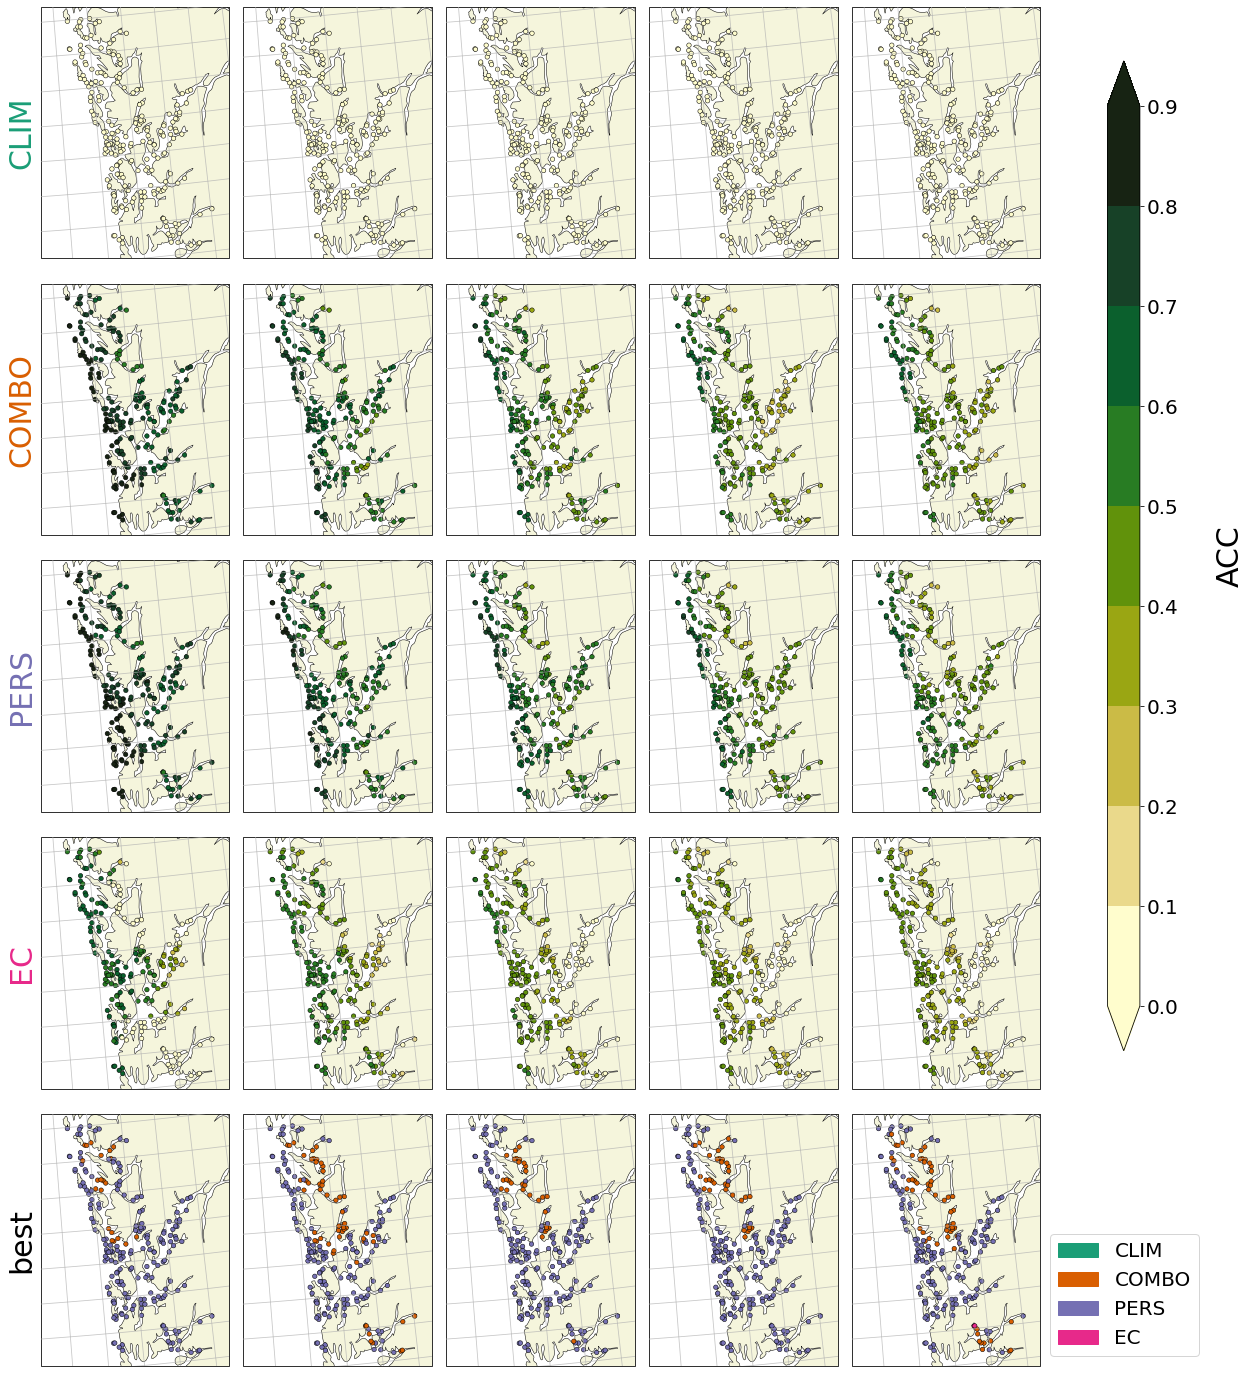

In [21]:
nrm = BoundaryNorm(np.arange(0,.901,.1),256)

n_mod = len(corr_coll.mod)
cols = [mpl_cm.Dark2(i) for i in range(n_mod)]
handles = [matplotlib.patches.Patch(color=mpl_cm.Dark2(i), label=c) for i, c in enumerate(mod_name)]

f,ax = plt.subplots(n_mod+1,len(obs_anom.step),figsize=(18,25),subplot_kw=dict(projection=ccrs.NorthPolarStereo()))

for mm in corr_coll.mod:
    cs = make_row(ax[mm.values],corr_coll.sel(mod=mm.values),nrm=nrm,model=mod_name[mm.values],col=cols[mm.values])

plt.subplots_adjust(wspace=0.05,hspace=0.1)

cax = f.add_axes([.95,.3,.025,.55])
cba = plt.colorbar(cs,cax=cax,extend='both')
cba.set_label('\nACC',fontsize=30)
cba.ax.tick_params(labelsize=20)

nrm_bst = BoundaryNorm(np.arange(n_mod),n_mod-1)
make_best_row(ax[n_mod],best_mod_corr,nrm=nrm_bst)
ax[-1,-1].legend(handles=handles,bbox_to_anchor=(1,0),loc='lower left',fontsize=20)

f.savefig(FPATH + 'ACC_Hardanger_ann.pdf',bbox_inches='tight')
f.savefig(FPATH + 'ACC_Hardanger_ann.png',bbox_inches='tight',dpi=400)

In [22]:
# MAE:
mae_coll = xr.concat([mae_ex_CLM,mae_ex_CMB,mae_ex_PRS,mae_ex_EC],dim='mod') #mae_ex_CMB_adj,mae_ex_PRS_adj,
best_mod_mae = mae_coll.argmin('mod')

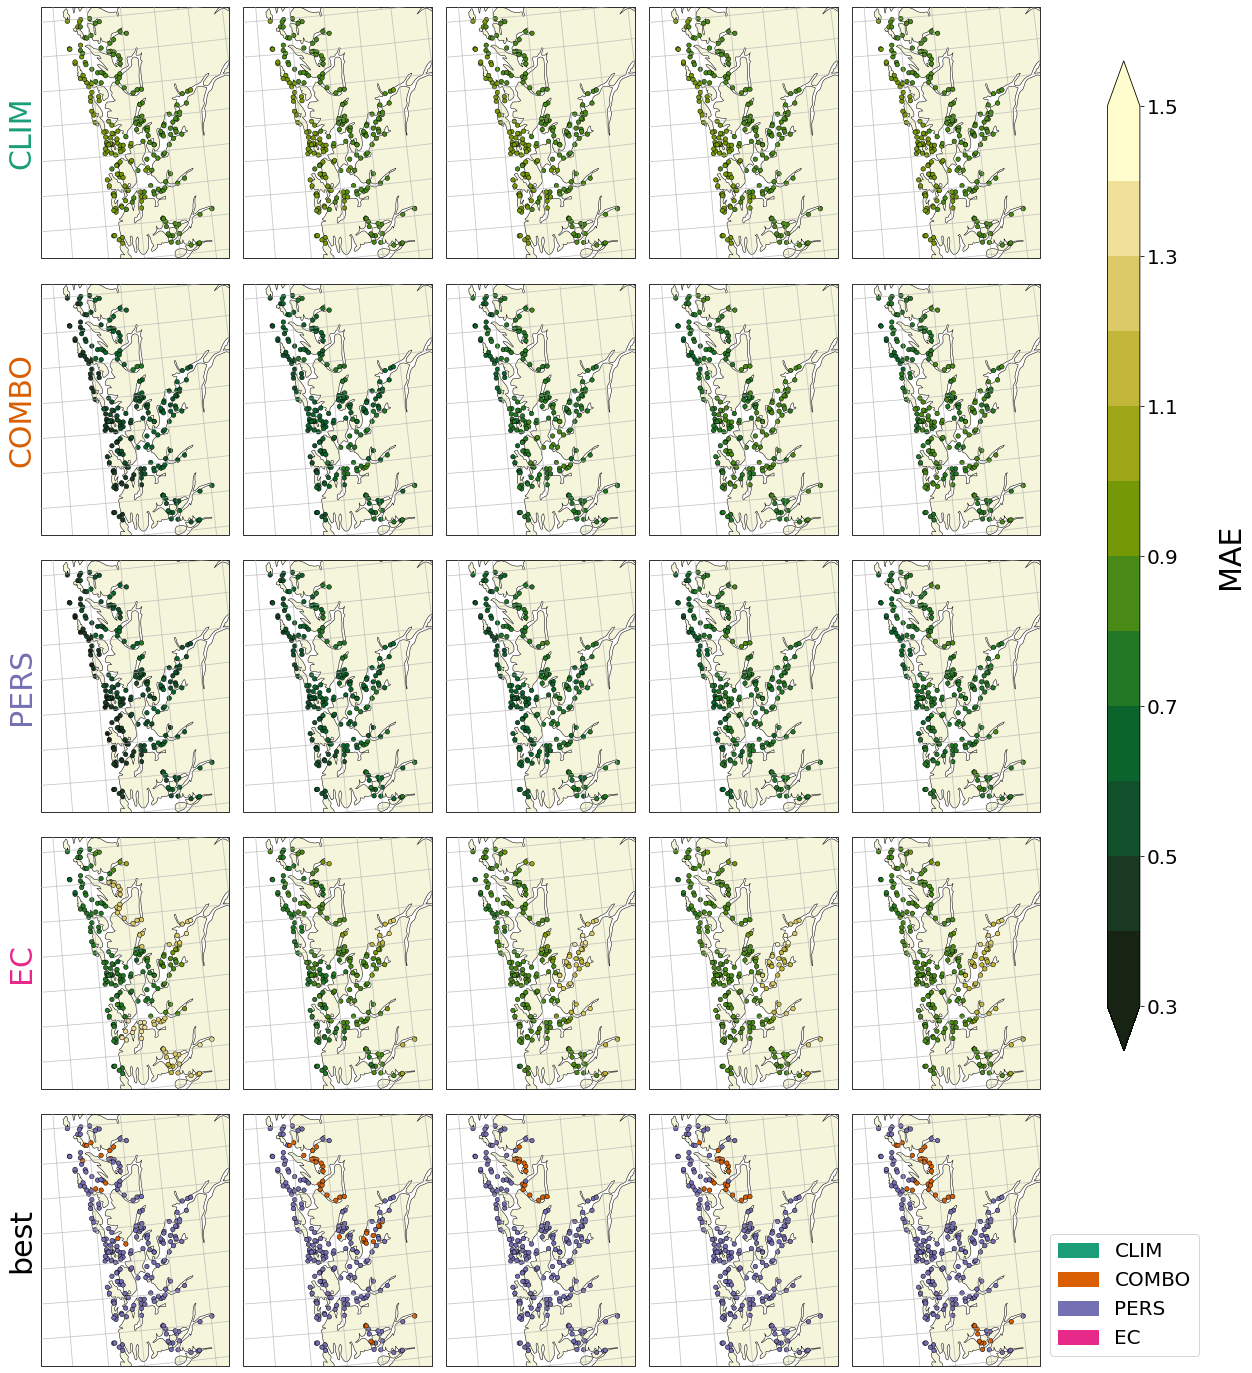

In [23]:
nrm = BoundaryNorm(np.arange(.3,1.501,.1),256)

f,ax = plt.subplots(n_mod+1,len(obs_anom.step),figsize=(18,25),subplot_kw=dict(projection=ccrs.NorthPolarStereo()))

for mm in mae_coll.mod:
    cs = make_row(ax[mm.values],mae_coll.sel(mod=mm.values),nrm=nrm,model=mod_name[mm.values],col=cols[mm.values],cmap=cmocean.cm.speed_r)
plt.subplots_adjust(wspace=0.05,hspace=0.1)

cax = f.add_axes([.95,.3,.025,.55])
cba = plt.colorbar(cs,cax=cax,extend='both')
cba.set_label('\nMAE',fontsize=30)
cba.ax.tick_params(labelsize=20)

nrm_bst = BoundaryNorm(np.arange(n_mod),n_mod-1)
make_best_row(ax[n_mod],best_mod_mae,nrm=nrm_bst)
ax[-1,-1].legend(handles=handles,bbox_to_anchor=(1,0),loc='lower left',fontsize=20)

f.savefig(FPATH + 'MAE_Hardanger_ann.pdf',bbox_inches='tight')
f.savefig(FPATH + 'MAE_Hardanger_ann.png',bbox_inches='tight',dpi=400)

In [24]:
# CRPS:
crps_coll = xr.concat([crps_ex_CLM,crps_ex_CMB,crps_ex_PRS,crps_ex_EC],dim='mod') #crps_ex_CMB_adj,crps_ex_PRS_adj,
best_mod_crps = crps_coll.argmin('mod')

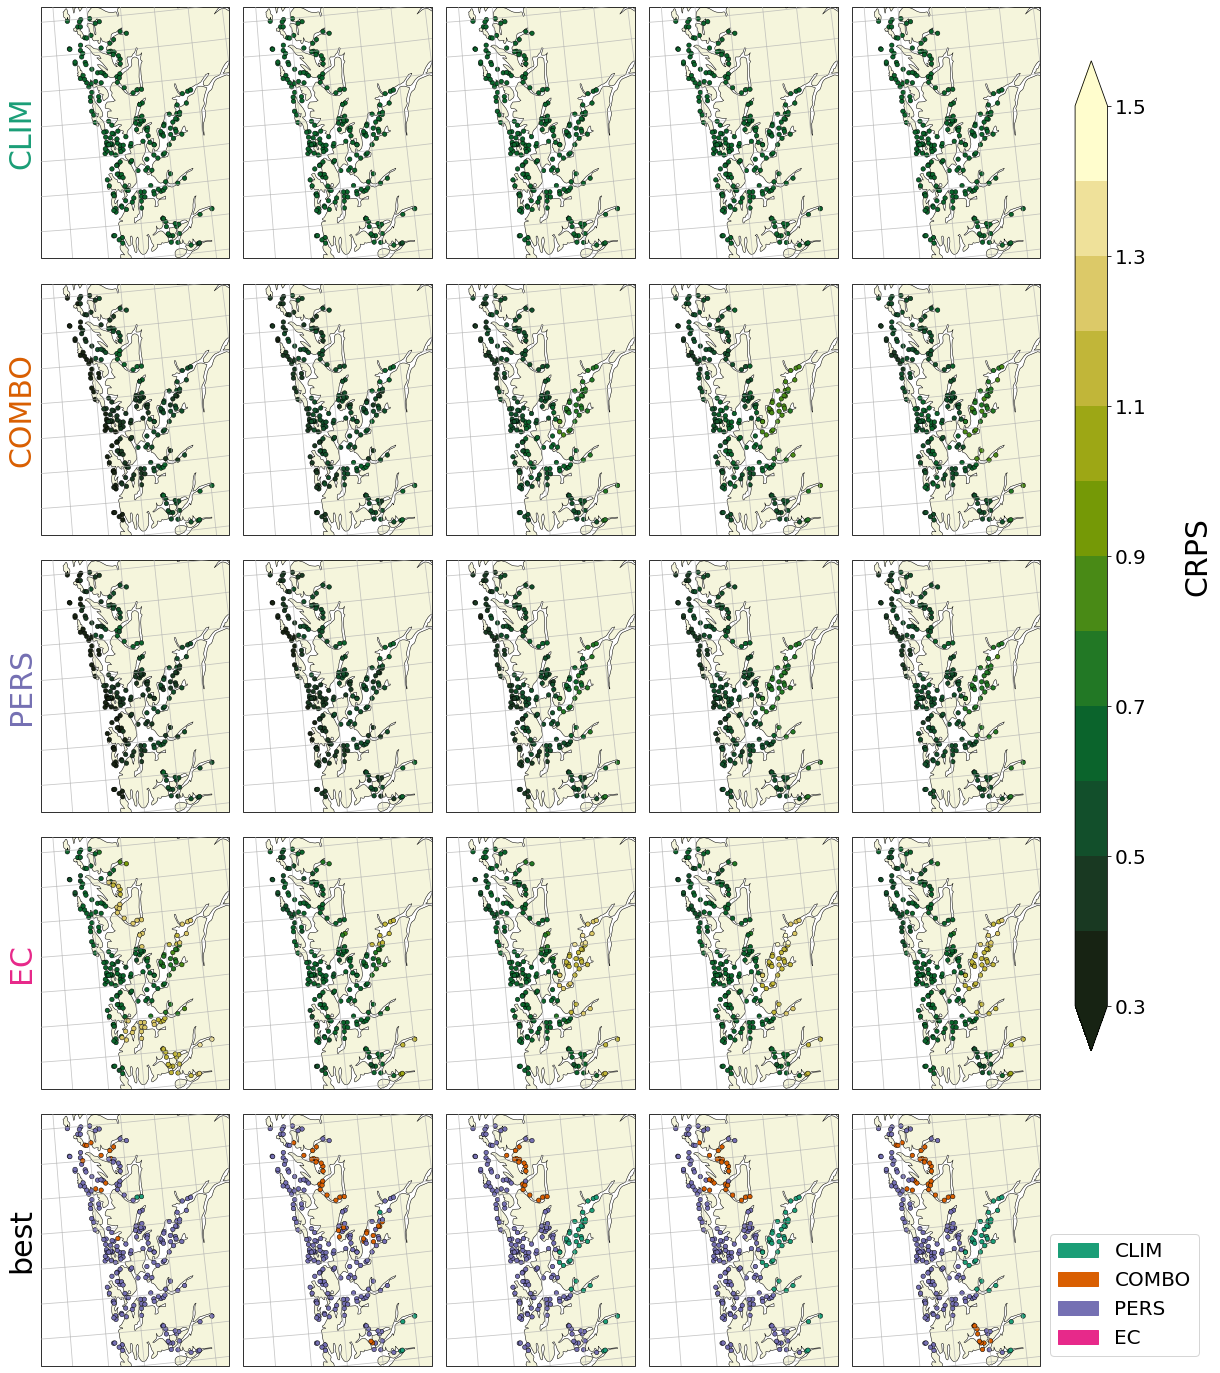

In [25]:
nrm = BoundaryNorm(np.arange(.3,1.501,.1),256)

f,ax = plt.subplots(n_mod+1,len(obs_anom.step),figsize=(18,25),subplot_kw=dict(projection=ccrs.NorthPolarStereo()))
for mm in crps_coll.mod:
    cs = make_row(ax[mm.values],crps_coll.sel(mod=mm.values),nrm=nrm,model=mod_name[mm.values],col=cols[mm.values],cmap=cmocean.cm.speed_r)

plt.subplots_adjust(wspace=0.05,hspace=0.1)

cax = f.add_axes([.925,.3,.025,.55])
cba = plt.colorbar(cs,cax=cax,extend='both')
cba.set_label('\nCRPS',fontsize=30)
cba.ax.tick_params(labelsize=20)

nrm_bst = BoundaryNorm(np.arange(n_mod),n_mod-1)
make_best_row(ax[n_mod],best_mod_crps,nrm=nrm_bst)
ax[-1,-1].legend(handles=handles,bbox_to_anchor=(1,0),loc='lower left',fontsize=20)

f.savefig(FPATH + 'CRPS_Hardanger_ann.pdf',bbox_inches='tight')
f.savefig(FPATH + 'CRPS_Hardanger_ann.png',bbox_inches='tight',dpi=400)

In [26]:
obs_exp = xr.Dataset(
    data_vars=dict(
        obs_an=([EC_bc.dims[-1],*EC_bc.dims[:-1]], obs_anom.expand_dims('member').values)
    ),
    coords=dict(
        time=(['time'], EC_bc.time.values),
        member=(['member'], [11]),
        step=(['step'], EC_bc.step.values),
        location=(['location'], EC_bc.location.values),
    )
).obs_an

In [54]:
obs_rank = xr.concat([EC_bc,obs_exp],dim='member').rank('member').sel(member=11)

In [55]:
LOCN = 100

(array([199.,  32.,  21.,  16.,  20.,  20.,  15.,  22.,  18.,  22., 290.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.]),
 <BarContainer object of 11 artists>)

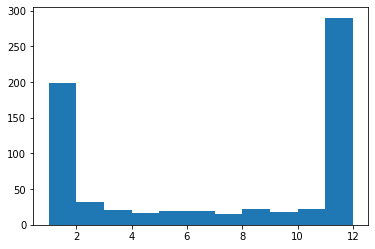

In [56]:
plt.hist(obs_rank.isel(step=0,location=LOCN).values,11)

In [57]:
obs_anom.isel(step=3,location=LOCN).std()

<xarray.DataArray 'sst' ()>
array(1.18857944)
Coordinates:
    step      timedelta64[ns] 30 days
    depth     float32 0.0
    location  <U5 '20595'
    loc_name  object ...
    lon       float64 5.208
    lat       float64 60.16

In [62]:
# MSE vs. intra-ensemble variance
# MSE = ((PRS_wspread.mean('member') - obs_anom)**2).mean('time')
# IEV = 12/11*PRS_wspread.var(('member','time'))
# MSE vs. intra-ensemble variance
MSE = ((EC_bc.mean('member') - obs_anom)**2).mean('time')
IEV = 2/1*EC_bc.var(('time','member'))

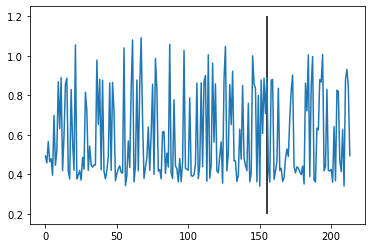

In [63]:
plt.plot((MSE.isel(step=0)/IEV.isel(step=0)).values)
plt.vlines(155,.2,1.2,'k')

No handles with labels found to put in legend.


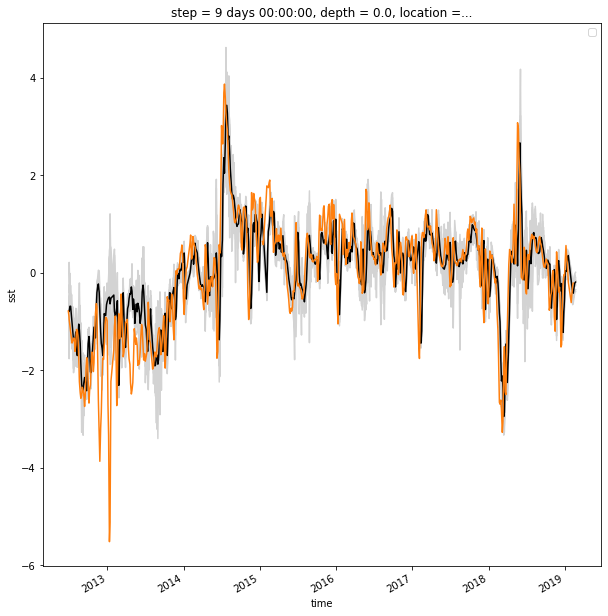

In [59]:
plt.figure(figsize=(10,10))
PRS_wspread.isel(step=0,location=LOCN).plot(hue='member',color='lightgrey',label='')
PRS_wspread.isel(step=0,location=LOCN).mean('member').plot(hue='member',color='k',label='')
obs_anom.isel(step=0,location=LOCN).plot(color='C1')
plt.legend()

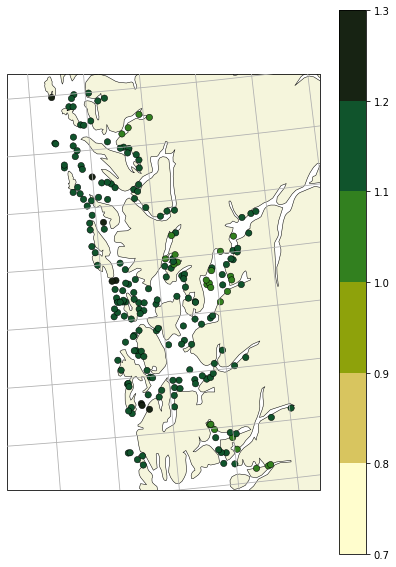

In [30]:
f,ax = plt.subplots(figsize=(7,10),subplot_kw=dict(projection=ccrs.NorthPolarStereo()))

ax.add_feature(coast, edgecolor='k', linewidth=0.5)
ax.set_extent(extent, crs=ccrs.PlateCarree())

nrm = BoundaryNorm(np.arange(.7,1.31,.1),256,clip=True)

cs = ax.scatter(
    obs_anom.lon,
    obs_anom.lat,
    c = obs_anom.std('time').isel(step=0).values,
    s = 40,
    transform=ccrs.PlateCarree(),
    cmap=cmocean.cm.speed,
    norm=nrm,
    edgecolors='black',
    linewidth=0.5,
    zorder=10
)

gl = ax.gridlines(
    draw_labels=False,
    dms=True,
    x_inline=False,
    y_inline=False,
    zorder=101,
    alpha=1
)
gl.xlabel_style = {'fontsize':11}
gl.ylabel_style = {'fontsize':11}

plt.colorbar(cs)


In [44]:
nk_path = dpath + "norkyst_at_locations_hardanger_stationary_kindex.nc"

with xr.open_dataarray(nk_path) as norkyst:
    norkyst = norkyst.sortby("time")

print('Norkyst: roll')
norkyst = norkyst.rolling(time=7,center=True).mean()

hindcast = fit_models.HC()
# observations = Observations(
#         name='norkyst_at_locations_hardanger_stacked_and_processed',
#         observations=norkyst,
#         forecast=hindcast,
#         process=True   
#     )
# observations.data_a.to_netcdf(dpath+'norkyst_at_locations_hardanger_anomalies.nc')

Norkyst: roll


In [46]:
NK_raw = norkyst.dropna('time')

In [47]:
NK_raw.sel(location=)

<xarray.DataArray 'sst' (time: 2386, location: 214)>
array([[11.808063 , 11.269128 , 12.059636 , ..., 12.1407385, 12.286616 ,
        11.75689  ],
       [12.094379 , 11.515887 , 12.098774 , ..., 12.320314 , 12.41502  ,
        11.826273 ],
       [12.406962 , 11.776983 , 12.139586 , ..., 12.551167 , 12.567492 ,
        11.894085 ],
       ...,
       [ 4.0960517,  4.939102 ,  4.30805  , ...,  4.0352373,  3.4496374,
         4.663047 ],
       [ 4.1407366,  4.9472647,  4.211042 , ...,  4.093526 ,  3.420336 ,
         4.611979 ],
       [ 4.181444 ,  4.967462 ,  4.095511 , ...,  4.164582 ,  3.3817208,
         4.542179 ]], dtype=float32)
Coordinates:
    depth     float32 0.0
  * time      (time) datetime64[ns] 2012-06-30 2012-07-02 ... 2019-02-23
  * location  (location) object '30196' '15196' '10331' ... '11925' '29936'
    loc_name  (location) object 'Ådnekvamme' 'Aga Ø' ... 'Ystadneset'
    lon       (location) float64 5.355 5.261 6.045 5.572 ... 6.208 6.021 5.776
    lat       (location) float64 60.83 59.85 60.11 60.25 ... 60.26 59.4 59.98
Attributes:
    standard_name:  sea_water_potential_temperature
    long_name:      potential temperature
    units:          Celsius
    time:           time
    grid_mapping:   polar_stereographic